<a href="https://colab.research.google.com/github/gerritgr/MoleculeDiffusionGAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💊🌀 MoleculeDiffusionGAN 🌀💊

## Setup

In [ ]:
# This is used for the naming of files and folders
PROJECT_NAME = "MoldDiffGAN"
PATH_PATTERN_BASE = "moldiffgan1"
PATH_PATTERN = PATH_PATTERN_BASE

# Setting BASELINE to True would deactivate the discriminator.
BASELINE = False
DEBUG = False


### Handle Colab

On Colab, we need to install some additional packages.
If running on Colab, we use Google Drive to store results.

In [ ]:
import os
import torch

# Check for Google Colab and WandB
USE_COLAB = False
try:
  from google.colab import drive
  USE_COLAB = True
except:
  pass

try:
  import wandb # need to do this before chaning CWD
except:
  os.system("pip install wandb")

# Load Google Drive
if USE_COLAB:
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  dir_path = f'/content/drive/MyDrive/colab/{PROJECT_NAME}/'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  print("Current Working Directory: ", os.getcwd())
  if os.getcwd() != dir_path:
    os.chdir(dir_path)
    print("New Working Directory: ", os.getcwd())


torch_version = torch.__version__.split("+")
try:
  import torch_geometric
except:
  os.system("pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html")
  os.system("pip install torch-geometric")

try:
  import rdkit
except:
  os.system("pip install rdkit")


Mounted at /content/drive
Current Working Directory:  /content
New Working Directory:  /content/drive/MyDrive/colab/MoldDiffGAN_run3


### Imports

In [ ]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # Set this to 300 to get better image quality
import seaborn as sns

import networkx as nx
import glob
import random
import os
import traceback
import time
import copy
import pickle
import numpy as np
import math
from tqdm import tqdm
import gzip

from rdkit import Chem
from rdkit.Chem import Draw

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import Sequential as Seq
from torch.nn import Linear as Lin
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    PNA,
    GATv2Conv,
    GraphNorm,
    BatchNorm,
    global_mean_pool,
    global_add_pool
)
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx, degree

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

In [ ]:
# Load code to convert molecules to pyg tensors if using Colab
if USE_COLAB and not os.path.exists("smiles_to_pyg"):
  os.system("git clone https://github.com/gerritgr/MoleculeDiffusionGAN.git && cp -R MoleculeDiffusionGAN/* .")

from smiles_to_pyg.molecule_load_and_convert import *

## Hyperparams

In [ ]:
##
## Diffusion
##
TIMESTEPS = 1000
START = 0.0001
END = 0.015

# Training
BATCH_SIZE = 256
GAMMA = 0.1

##
## Prediction/Denoising
##
LEARNING_RATE_GEN = 0.001
EPOCHS_GEN = 60

# PNA Pred
DROPOUT_PRED = 0.05
DEPTH_PRED = 4
HIDDEN_CHANNELS_PRED = 32
TOWERS_PRED = 1
NORMALIZATION_PRED = True

##
## Discriminator
##
EPOCHS_DISC_MODEL = 70
DISC_NOISE = 0.3

# PNA Disc
HIDDEN_CHANNELS_DISC = 8
DEPTH_DISC = 4
DROPOUT_DISC = 0.03
NORMALIZATION_DISC = True

##
## Molecule Encoding
##
INDICATOR_FEATURE_DIM = 1
FEATURE_DIM = 5  # (has to be the same for atom and bond)
ATOM_FEATURE_DIM = FEATURE_DIM
BOND_FEATURE_DIM = FEATURE_DIM
NON_NODES = [True] + [False] * 5 + [True] * 5
NON_EDGES = [True] + [True] * 5 + [False] * 5

TIME_FEATURE_DIM = 1


## Utils

In [ ]:
def log(d):
  try:
    import wandb
    wandb.log(d)
  except:
    print(d)


def load_file(filepath):
  print("Trying to read", filepath)
  try:
    with gzip.open(filepath, 'rb') as f:
      return pickle.load(f)
  except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise


def write_file(filepath, data):
  try:
    data = data.cpu()
  except:
    pass
  print("Trying to write", filepath)
  with gzip.open(filepath, 'wb') as f:
    pickle.dump(data, f)


In [ ]:
def build_dataset(seed=1234):
  try:
    dataset_train, dataset_test = load_file('dataset.pickle')
    if DEBUG:
      return dataset_train[:len(dataset_train) // 10], dataset_test[:len(dataset_test) // 10]
    return dataset_train, dataset_test
  except Exception as e:
    print(f"Could not load dataset due to error: {str(e)}, generate it now")

  dataset = read_qm9()
  dataset_all = [g for g in dataset if g.x.shape[0] > 1]
  dataset = list()

  for g in tqdm(dataset_all):
    try:
      assert "None" not in str(pyg_to_smiles(g))
      dataset.append(g)
    except:
      pass

  print(f"Built and cleaned dataset, length is {len(dataset)}, old length was {len(dataset_all)}")
  random.Random(seed).shuffle(dataset)
  split = int(len(dataset) * 0.8 + 0.5)
  dataset_train = dataset[:split]
  dataset_test = dataset[split:]
  assert(dataset_train[0].x[0, :].numel() == INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM)

  write_file("dataset.pickle", (dataset_train, dataset_test))
  return dataset_train, dataset_test


In [ ]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
  """
  Generates a schedule of beta and alpha values for a forward process.

  Args:
  start (float): The starting value for the beta values. Default is START.
  end (float): The ending value for the beta values. Default is END.
  timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

  Returns:
  tuple: A tuple of three tensors containing the beta values, alpha values, and
  cumulative alpha values (alpha bars).
  """
  betas = torch.linspace(start, end, timesteps, device = DEVICE)
  assert(betas.numel() == TIMESTEPS)
  return betas

In [ ]:
def visualize_smiles_from_file(filepath):
    print("Visualize molecules.")
    # Read SMILES from file
    with open(filepath, 'r') as file:
        smiles_list = [line.split("'")[1] for line in file.readlines() if "'" in line]

    # Convert SMILES to RDKit Mol objects, filtering out invalid ones
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list[:100]]
    mols = [mol for mol in mols if mol is not None]

    if len(mols) == 0:
        return

    # Determine grid size
    num_mols = len(mols)
    cols = 10
    rows = min(10, -(-num_mols // cols))  # ceil division

    # Create a subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20),
                            gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")  # hide axis
            idx = i * cols + j  # index in mols list
            if idx < num_mols:
                img = Draw.MolToImage(mols[idx], size=(200, 200))
                ax.imshow(img)
            else:
                break

    # Save the figure
    plt.savefig(filepath + '.jpg', format='jpg', bbox_inches='tight')

    time.sleep(0.01)
    try:
        wandb.log_artifact(filepath + '.jpg', name=f"jpg_{SWEEP_ID}_{filepath.replace('.','')}", type="smiles_grid_graph")
    except:
        pass

In [ ]:
def get_pred_from_noise(noise_pred, x_with_noise, future_t):
  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(1.0 - alphabar_t)
  x_without_noise = x_with_noise - scaled_noise * noise_pred
  x_without_noise = x_without_noise / torch.sqrt(alphabar_t)
  return x_without_noise


def get_noise_from_pred(original_pred, x_with_noise, future_t):
  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(alphabar_t)
  noise = x_with_noise - scaled_noise * original_pred
  noise = noise / torch.sqrt(1.0 - alphabar_t)

  return noise


In [ ]:
def log_smiles(smiles, filename):
  try:
    with open(filename, "w") as file:
      for string in smiles:
        file.write(str(string) + "\n")

    try:
      wandb.log_artifact(filename, name=f"src_txt_{SWEEP_ID}_{filename}", type="smiles")
    except Exception as e:
      print(e)

    time.sleep(0.01)
    visualize_smiles_from_file(filename)
  except Exception as e:
    print("An error occurred during training: \n", str(e))
    traceback.print_exc()


## Forward Process

In [ ]:
def forward_diffusion(node_features, future_t):
  """
  Performs a forward diffusion process on an node_features tensor.
  Each row can theoreetically have its own future time point.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  row_num = node_features.shape[0]

  if "class 'int'" in str(type(future_t)) or "class 'float'" in str(type(future_t)):
    future_t = torch.tensor([int(future_t)] * row_num).to(DEVICE)

  feature_dim = node_features.shape[1]
  future_t = future_t.view(-1)
  assert(row_num == future_t.numel())
  assert(future_t[0] == future_t[1]) # Let's assume they belong to the same graph.

  betas = generate_schedule()

  noise = torch.randn_like(node_features, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)
  assert(alphabar_t.numel() == row_num)

  new_node_features_mean = torch.sqrt(alphabar_t) * node_features # Column-wise multiplication, now it is a matrix
  assert(new_node_features_mean.shape == node_features.shape)
  new_node_features_std = torch.sqrt(1.-alphabar_t) # This is a col. vector
  new_node_features_std = new_node_features_std.repeat(1,feature_dim) # This is a matrix
  assert(new_node_features_mean.shape == new_node_features_std.shape)
  noisey_node_features =  new_node_features_mean + new_node_features_std * noise

  return noisey_node_features, noise

#forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([0,0,999], device=DEVICE)), print(""), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([999,999,999], device=DEVICE))

## Denoising NN

In [ ]:
def dataset_to_degree_bin(train_dataset):
  """
  Convert a dataset to a histogram of node degrees (in-degrees).
  Load from file if available; otherwise, compute from the dataset.
  """
  try:
    # Attempt to load the degree histogram from a file.
    deg = load_file('deg.pickle')
    deg = deg.to(DEVICE)
    return deg
  except Exception as e:
    print(f"Could not find degree bin due to error: {str(e)}, generate it now")

  # Assert that the dataset is provided.
  assert(train_dataset is not None)

  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  # Create an empty histogram for degrees.
  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)

  # Populate the histogram with data from the dataset.
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

  # Save the computed histogram to a file.
  write_file("deg.pickle", deg.cpu())

  return deg


In [ ]:
class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_PRED, depth=DEPTH_PRED, dropout=DROPOUT_PRED, towers=TOWERS_PRED, normalization=NORMALIZATION_PRED, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Adjust hidden channels for the given towers.
    hidden_channels = towers * ((hidden_channels // towers) + 1) # must match

    # Calculate input and output channels.
    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM + TIME_FEATURE_DIM
    out_channels = FEATURE_DIM

    # Get degree histogram for the dataset
    deg = dataset_to_degree_bin(train_dataset)

    # Set aggregators and scalers for the PNA layer.
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']

    # Create a normalization layer if required.
    self.normalization = BatchNorm(hidden_channels) if normalization else None

    # Define the PNA layer.
    self.pnanet = PNA(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=hidden_channels,
        num_layers=depth,
        aggregators=aggregators,
        scalers=scalers,
        deg=deg,
        dropout=dropout,
        towers=towers,
        norm=self.normalization,
        pre_layers=pre_post_layers,
        post_layers=pre_post_layers
    )

    # Define the final MLP layer.
    self.final_mlp = Seq(
        Lin(hidden_channels, hidden_channels),
        nn.ReLU(),
        Lin(hidden_channels, hidden_channels),
        nn.ReLU(),
        Lin(hidden_channels, out_channels)
    )

  def forward(self, x_in, t, edge_index):
    """
    Perform a forward pass through the PNAnet.
    """
    row_num = x_in.shape[0]
    t = t.view(-1, TIME_FEATURE_DIM)
    x = torch.concat((x_in, t), dim=1)

    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)

    # Assertions for sanity checks
    assert(x.numel() > 1)
    assert(x.shape[0] == row_num)

    return x


In [ ]:
def load_latest_checkpoint(model, optimizer, loss_list, epoch_i, path_pattern_checkpoint=None):
  """
  Load the latest checkpoint from the disk.
  """
  if path_pattern_checkpoint is None:
    path_pattern_checkpoint = PATH_PATTERN + "_model_epoch_*.pth"

  try:
    checkpoint_paths = sorted(glob.glob(path_pattern_checkpoint))
    if len(checkpoint_paths) == 0:
      return model, optimizer, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path, map_location=DEVICE)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    loss_list = checkpoint['loss_list']

    print(f"Loaded checkpoint of epoch {epoch_i:08} from disk.")
  except Exception as e:
    print(f"Failed to load checkpoint. Error: {str(e)}")

  return model, optimizer, loss_list, epoch_i

def save_model(model, optimizer, loss_list, epoch_i, upload=False):
  """
  Save the model state to the disk.
  """
  if epoch_i == 0: # Relevant for load_base_model()
    return

  save_path = f"{PATH_PATTERN}_model_epoch_{epoch_i:08}.pth" # Will do lexicographical ordering to load.

  # Save the model and optimizer state dicts in a dictionary.
  torch.save({
    'epoch': epoch_i,
    'loss_list': loss_list,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
  }, save_path)

  if upload:
    try:
      wandb.log_artifact(save_path, name=f"weights_{SWEEP_ID}_{epoch_i:08}_weightfile", type="weight")
    except Exception as e:
      print(f"Failed to upload model. Error: {str(e)}")


In [ ]:
def load_base_model(dataset_train, path_pattern_checkpoint=None):
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)
  loss_list = None
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN)
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0, path_pattern_checkpoint=path_pattern_checkpoint)

  return model_base

## Inference / Reverse Process

There is a _normal_ and a _restart_ method for inference. The restart version is not implemented in this notebook.

In [ ]:
def denoise_one_step(model, g, i):
  """
  Performs one step of denoising using the provided model.
  """
  row_num = g.x.shape[0]

  # Generate and calculate betas, alphas, and related parameters
  betas = generate_schedule()
  t = TIMESTEPS - i - 1  # i=0 indicates full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

  # Create the mask
  mask = torch.concat(
      (torch.tensor([False] * g.x_old.shape[0], device=DEVICE).view(-1, 1),
       g.x_old[:, 1:] > -0.5),
      dim=1
  )

  # Define future_t for the model predictions
  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1, 1)
  original_pred = model(g.x, future_t, g.edge_index)

  # Extract noisy values and predict noise
  x_with_noise = g.x[mask].view(row_num, -1)
  future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  noise_pred = get_noise_from_pred(original_pred, x_with_noise, future_t)

  # Set endpoints values
  values_now = g.x[mask].view(row_num, -1)
  values_endpoint = noise_pred.view(row_num, -1)
  assert values_now.shape == values_endpoint.shape

  # Compute denoised values
  model_mean = sqrt_recip_alphas_t * (values_now - beta_t * values_endpoint / sqrt_one_minus_alphas_cumprod_t)
  values_one_step_denoised = model_mean  # in case that t == 0

  if t != 0:
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)  # in the paper this is in 3.2. Note that sigma^2 is variance, not std.
    posterior_std_t = torch.sqrt(posterior_variance[t])
    noise = torch.randn_like(values_now, device=DEVICE)
    values_one_step_denoised = model_mean + posterior_std_t * noise

  # Clone and update with denoised values
  denoised_x = g.x.clone()
  denoised_x[mask] = values_one_step_denoised.flatten()

  return denoised_x


In [ ]:
def overwrite_with_noise(g):
  g.x_old = g.x.clone()
  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  g.x[mask] = torch.randn_like(g.x[mask])
  return g


In [ ]:
@torch.inference_mode()
def generate_examples(model, dataset_train, num=100, restart_inference_method=False):
  """
  Generate graph samples in batches using the provided model.
  """
  # Setup
  print("generate samples batched")
  model.eval()
  dataset_train_start = list()

  while len(dataset_train_start) < num:
    g = dataset_train[random.choice(range(len(dataset_train)))]
    dataset_train_start.append(g.clone().to(DEVICE))

  #old
  #while len(dataset_train_start) < num:
  #  g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
  #  dataset_train_start.append(g.clone().to(DEVICE))
  #  g = dataset_train_start[-1]

  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size=num)

  # Inference
  for g in dataloader:
    g = g.to(DEVICE)
    print("load g", g, g.batch)
    g = overwrite_with_noise(g)

    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS - i - 1)
      if restart_inference_method:
        x_with_less_noise = denoise_one_step_restart(model, g, i) #todo
      else:
        x_with_less_noise = denoise_one_step(model, g, i)
      g.x = x_with_less_noise

    graph_list = g.to_data_list()
    graph_list = [g.cpu() for g in graph_list]

    print("generated graphs ", graph_list[:10])
    return graph_list


In [ ]:
from tqdm import tqdm

def find_frac_correct(graphs):
  """
  Determine the fraction and unique of correct graphs based on their conversion to SMILES.
  """
  correct = 0
  smiles_list = list()

  for i, g in tqdm(enumerate(graphs)):
    smiles = pyg_to_smiles(g)
    if smiles and '.' not in smiles:
      mol = Chem.MolFromSmiles(smiles)
      if mol:
        correct += 1
        smiles_list.append((smiles, i))

  frac_correct = correct / len(graphs)
  smiles_list_0 = [s[0] for s in smiles_list]
  unique_frac = len(set(smiles_list_0)) / len(graphs)

  return frac_correct, smiles_list, unique_frac


In [ ]:
def gen_graphs(num_per_generation=1000, num_generations=40, restart_inference_method=False, model_path=None):
  """
  Generate a specified number of graphs.
  """
  print(f"Generate {num_generations*num_per_generation} graphs.")
  if DEBUG:
    num_generations = int(num_generations / 10)

  if model_path is None:
    model_path = PATH_PATTERN + "_model_epoch_*.pth"

  path = sorted(glob.glob(model_path))[-1]
  num_samples = num_per_generation * num_generations
  filepath = path.replace(".pth", f'_{num_samples:06d}_w{restart_inference_method}_generated.pickle')

  results = list()
  try:
    results = load_file(filepath)
  except:
    pass

  if len(results) == num_samples:
    return results

  dataset_base, dataset_base_test = build_dataset()
  model_base = load_base_model(dataset_base, path_pattern_checkpoint=path)

  i = 0
  while len(results) < num_samples:
    i += 1
    num = max(num_per_generation, len(results) - num_samples)
    graphs = generate_examples(model_base, dataset_base, num=num, restart_inference_method=restart_inference_method)
    results.extend(graphs)
    if i % 5 == 0 or len(results) >= num_samples:
      write_file(filepath, results)

  assert(len(results) == num_samples)
  return results


def test_graph_generation(path_pattern=None, restart_inference_method=False):
  generated_graphs = gen_graphs(restart_inference_method=restart_inference_method, model_path=path_pattern)
  return find_frac_correct(generated_graphs)

## Discriminator NN

In [ ]:
from torch_geometric.nn import PNA

class PNAdisc(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=HIDDEN_CHANNELS_DISC,
               depth=DEPTH_DISC, dropout=DROPOUT_DISC, towers=1,
               normalization=NORMALIZATION_DISC, pre_post_layers=1):
    super(PNAdisc, self).__init__()

    self.sigmoid = nn.Sigmoid()

    # Adjust hidden channels based on towers
    hidden_channels = towers * ((hidden_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM
    assert in_channels == 11

    deg = dataset_to_degree_bin(train_dataset).to(DEVICE)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels,
                     hidden_channels=hidden_channels,
                     out_channels=1,
                     num_layers=depth,
                     aggregators=aggregators,
                     scalers=scalers,
                     deg=deg,
                     dropout=dropout,
                     towers=towers,
                     norm=self.normalization,
                     pre_layers=pre_post_layers,
                     post_layers=pre_post_layers)

  def forward(self, x, edge_index, batch=None):
    x = x + torch.randn_like(x) * DISC_NOISE
    x = self.pnanet(x, edge_index)
    x = global_mean_pool(x, batch)
    x = self.sigmoid(x)

    return x

In [ ]:
def train_epoch_disc(model_disc, dataloader, optimizer):
  model_disc.train()
  start_time = time.time()
  loss_list = []
  acc_list = []

  for batch in dataloader:
    batch = batch.to(DEVICE)
    optimizer.zero_grad()
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    loss.backward()
    optimizer.step()

    acc = (torch.abs(pred.flatten() - batch.y.flatten()) < 0.5).float()
    acc_list.extend(acc.detach().cpu().tolist())
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time() - start_time

In [ ]:
def test_disc(model_disc, dataloader):
  model_disc.eval()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def train_disc_model(dataloader_disc, dataloader_disc_test, round_i):
  model_disc = PNAdisc(dataloader_disc).to(DEVICE)
  weight_path = f"{PATH_PATTERN}_discriminator_model_round_{round_i:05}.pth"

  try:
    checkpoint = torch.load(weight_path)
    model_disc.load_state_dict(checkpoint['model_state_dict'])
    print(f"found disc model in round {round_i:05}")
    return model_disc
  except:
    pass

  epochs = []
  losses_train = []
  losses_test = []

  optimizer_disc = Adam(model_disc.parameters(), lr=0.0001)
  for epoch_i in range(EPOCHS_DISC_MODEL):
    loss_train, acc_train, t_train = train_epoch_disc(model_disc, dataloader_disc, optimizer_disc)
    if epoch_i % 10 == 1 or epoch_i == EPOCHS_DISC_MODEL - 1:
      loss_test, acc_test, t_test = test_disc(model_disc, dataloader_disc_test)
      print(f"train discriminator: epoch: {epoch_i:05}, loss: {loss_train:.4f}, loss test: {loss_test:.4f}, acc: {acc_train:.3f}, acc test: {acc_test:.3f}, time: {t_train:.3f}")
      log({
          "disc/step": epoch_i,
          "disc/epoch": epoch_i,
          "disc/loss_train": loss_train,
          'disc/loss_test': loss_test,
          "disc/acc_train": acc_train,
          "disc/acc_test": acc_test,
          "disc/time": t_train
      })
      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)

  # Plotting losses
  plt.clf()
  plt.plot(epochs, losses_train, label='train')
  plt.plot(epochs, losses_test, label='test')
  plt.legend()
  plt.savefig(f"discriminator_model_{round_i:05}.png")

  torch.save({
      'model_state_dict': model_disc.state_dict(),
      'epochs': epochs,
      "losses_train": losses_train,
      "losses_test": losses_test
  }, weight_path)

  return model_disc


In [ ]:
def run_disc(round_i=1):
  print(f"Train discriminator round {round_i}.")
  fake_graphs = gen_graphs(restart_inference_method=False)
  dataset_base, dataset_base_test = build_dataset()
  real_graphs = random.sample(dataset_base, len(fake_graphs))
  dataset = list()

  for g in fake_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(0.0)
    dataset.append(g_i)

  for g in real_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(1.0)
    dataset.append(g_i)

  random.shuffle(dataset)
  cut_off = int(len(dataset) * 0.8)
  dataloader_train = DataLoader(dataset[:cut_off], batch_size = BATCH_SIZE, shuffle=True)
  dataloader_test = DataLoader(dataset[cut_off:], batch_size = BATCH_SIZE, shuffle=True)

  model_disc = train_disc_model(dataloader_train, dataloader_test, round_i)
  return model_disc


## Train Jointly

In [ ]:
def train_epoch(model, dataloader, optimizer, model_disc=None):
  schedule = generate_schedule()
  model.train()
  start_time = time.time()
  loss_list = []
  loss_list_start = []

  for batch in tqdm(dataloader):
    if batch.x.shape[0] < 2:
      continue

    optimizer.zero_grad()
    batch = batch.to(DEVICE)
    row_num = batch.x.shape[0]

    num_graphs_in_batch = int(torch.max(batch.batch).item() + 1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device=DEVICE)
    future_t = torch.gather(future_t_select, 0, batch.batch)
    assert future_t.numel() == row_num

    mask = torch.cat((torch.tensor([False] * row_num, device=DEVICE).view(-1, 1), batch.x[:, 1:] > -0.5), dim=1)
    x_start_gt = batch.x[mask].view(row_num, FEATURE_DIM)
    x_with_noise, noise_gt = forward_diffusion(x_start_gt, future_t)

    x_in = batch.x.clone()
    x_in[mask] = x_with_noise.flatten()
    x_start_pred = model(x_in, future_t, batch.edge_index)
    loss = F.mse_loss(x_start_gt, x_start_pred)

    disc_loss = torch.tensor(0.0, device=DEVICE)
    if model_disc is not None:
      x_in[mask] = x_start_pred.flatten()
      disc_loss = torch.mean((1.0 - model_disc(x_in, batch.edge_index, batch=batch.batch))**2)
      loss = (1.0 - GAMMA) * loss + GAMMA * disc_loss

    loss.backward()
    loss_list.append(loss.item())
    loss_list_start.append(disc_loss.item())
    optimizer.step()

  return np.mean(loss_list), np.mean(loss_list_start), time.time() - start_time


In [ ]:
def train_base_model(train_loader, epoch_num=EPOCHS_GEN, model_disc=None):
  print("Train denoising model.")
  if DEBUG:
    epoch_num = int(epoch_num / 10)

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train).to(DEVICE)

  optimizer = Adam(model_base.parameters(), lr=LEARNING_RATE_GEN * 0.01) # the mutliplication makes no real sense
  loss_list = []
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0)
  epoch_start = min(epoch_start, epoch_num)
  print(f"from {epoch_start} to {epoch_num}")

  for epoch_i in range(epoch_start, epoch_num):
    try:
      loss, loss_start, time_elapsed = train_epoch(model_base, train_loader, optimizer, model_disc=model_disc)
      loss_list.append((epoch_i, loss))
      mean_loss = np.mean([y for _, y in loss_list] + [loss])
      print(f"loss in epoch {epoch_i:07} is: {loss:05.4f} with mean loss {mean_loss:05.4f} with start loss {loss_start:05.4f} with runtime {time_elapsed:05.4f}")
      log({
        "gen/step": epoch_i,
        "gen/epoch": epoch_i,
        "gen/loss": loss,
        "gen/mean_loss": mean_loss,
        "gen/start_loss": loss_start,
        "gen/runtime": time_elapsed
      })

      if (epoch_i % 20 == 0 and epoch_i > epoch_start) or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        print("save")
        save_model(model_base, optimizer, loss_list, epoch_i + 1, upload = epoch_i == epoch_num - 1)
        time.sleep(0.01)
        frac, smiles_list, unique_frac = test_graph_generation(restart_inference_method=False)
        frac_restart, smiles_list_restart, unique_frac_restart = 0, list(), 0 #test_graph_generation(restart_inference_method=True)
        print(f"Fraction of correct graphs: {frac}, with restart_inference_method inference {frac_restart}")
        log({
          "inference/step": epoch_i,
          "inference/epoch": epoch_i,
          "inference/frac_normal": frac,
          "inference/frac_restart": frac_restart,
          "inference/frac_normal_unique": unique_frac,
          "inference/frac_restart_unique": unique_frac_restart
        })
        log_smiles(smiles_list, f"{PATH_PATTERN}_smiles_{epoch_i}_normal.txt")
        log_smiles(smiles_list_restart, f"{PATH_PATTERN}_smiles_{epoch_i}_restart.txt")
        try:
          print(smiles_list[:20])
          print(smiles_list_restart[:20])
        except Exception as e:
          print(e)
    except Exception as e:
      print(f"An error occurred during training: \n{str(e)}")
      traceback.print_exc()
      raise e

  return model_base


### Putting Everything Together

In [ ]:
def start_experiments(rounds=7): #originally 5
  global DISC_NOISE
  if DEBUG:
    rounds = rounds // 2
  dataset_base, dataset_base_test = build_dataset()
  dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
  model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*1)

  for round_i in range(1, rounds):
    if BASELINE:
      model_disc = None
    else:
      model_disc = run_disc(round_i=round_i)
    model_base = train_base_model(dataloader_base, epoch_num = EPOCHS_GEN*(round_i+1), model_disc=model_disc)
    DISC_NOISE = DISC_NOISE*0.5

  save_src_file()
  return  model_base


### Start Training

In [ ]:
try:
  import wandb
except:
  # Train with discriminator (our method)
  start_experiments(rounds=5)
  # Train without discriminator (baseline)
  BASELINE = True
  start_experiments(rounds=5)

## Training with WandB

We can use WandB to save the training results.

In [ ]:
import wandb
print(wandb.__path__) # this should look like ['/usr/local/lib/python3.10/dist-packages/wandb']. Make sure to not install wandb into your current working dir.

['/usr/local/lib/python3.10/dist-packages/wandb']


In [ ]:
WANDB_TOKEN = "" # Add you WandB token here.

In [ ]:
sweep_config = {
    "name": "AliaMol",
    "method": "random",
    "metric": {
        "name": "inference/frac_normal_unique",
        "goal": "maximize",
    },
    "parameters": {
        "BATCH_SIZE": {"values": [256]},
        "GAMMA": {"values": [0.1]},
        "DISC_NOISE": {"values": [0.3]},
        "EPOCHS_DISC_MODEL": {"values": [100]},
        "EPOCHS_GEN": {"values": [100]},
    },
}

In [ ]:
def save_src_file():
  try:
    os.system("pip list > pip_list.txt 2>&1")
    for txt_file in sorted(glob.glob('*.txt')):
      z = "".join(filter(str.isalnum, txt_file))
      wandb.log_artifact(txt_file, name=f"src_txt_{SWEEP_ID}_{z}", type="my_dataset_txt")
    for python_file in sorted(glob.glob('*.ipynb')):
      z = "".join(filter(str.isalnum, python_file))
      wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}_{z}", type="my_dataset_ipynb")
    for python_file in sorted(glob.glob('*.py')):
      z = "".join(filter(str.isalnum, python_file))
      wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}_{z}", type="my_dataset_py")
  except Exception as e:
    print(e)




In [ ]:
def get_wand_api_key():
  global WANDB_TOKEN
  if len(WANDB_TOKEN) > 0:
    return WANDB_TOKEN
  import sys
  IN_COLAB = 'google.colab' in sys.modules
  if not IN_COLAB:
    os.system("cp ~/api_key.txt api_key.txt")
  file_path = 'api_key.txt'
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key


def main():
  global PATH_PATTERN
  with wandb.init() as run:
    PATH_PATTERN = PATH_PATTERN_BASE + '_' +str(run.name) + '_' +str(BASELINE)
    save_src_file()
    for hyper_param_name in sweep_config['parameters']:
      globals()[hyper_param_name] = run.config[hyper_param_name]
      print("set ", hyper_param_name, "=", run.config[hyper_param_name])
    start_experiments()

def start_with_wandb(set_baseline_true=False):
  global SWEEP_ID, USE_WANDB, PATH_PATTERN, BASELINE
  if set_baseline_true:
    BASELINE = True
  else:
    BASELINE = False
  USE_WANDB = True
  os.environ["WANDB_MODE"] = "online"
  try:
    SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
    wandb.agent(SWEEP_ID, function=main, count=5)
  except Exception as e:
    error_message = traceback.format_exc()
    print("final error:\n", error_message)
    with open('_error_log.txt', 'a') as f:
      f.write(error_message + '\n')
    time.sleep(10)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: js7xuq54
Sweep URL: https://wandb.ai/nextaid/MoldDiffGAN_run3/sweeps/js7xuq54


wandb: Agent Starting Run: x2z4l5ml with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.05
wandb: 	EPOCHS_DISC_MODEL: 60
wandb: 	EPOCHS_GEN: 60
wandb: 	GAMMA: 0.1
wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin


set  BATCH_SIZE = 256
set  GAMMA = 0.1
set  DISC_NOISE = 0.05
set  EPOCHS_DISC_MODEL = 60
set  EPOCHS_GEN = 60
Trying to read dataset.pickle
Train denoising model.
Trying to read deg.pickle
from 0 to 60


  0%|          | 0/419 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 419/419 [00:18<00:00, 22.62it/s]


loss in epoch 0000000 is: 0.1699 with mean loss 0.1699 with start loss 0.0000 with runtime 18.5387


100%|██████████| 419/419 [00:16<00:00, 25.54it/s]


loss in epoch 0000001 is: 0.1178 with mean loss 0.1352 with start loss 0.0000 with runtime 16.4155


100%|██████████| 419/419 [00:16<00:00, 26.16it/s]


loss in epoch 0000002 is: 0.0945 with mean loss 0.1192 with start loss 0.0000 with runtime 16.0315


100%|██████████| 419/419 [00:15<00:00, 27.20it/s]


loss in epoch 0000003 is: 0.0869 with mean loss 0.1112 with start loss 0.0000 with runtime 15.4139


100%|██████████| 419/419 [00:15<00:00, 26.80it/s]


loss in epoch 0000004 is: 0.0859 with mean loss 0.1068 with start loss 0.0000 with runtime 15.6413


100%|██████████| 419/419 [00:15<00:00, 26.54it/s]


loss in epoch 0000005 is: 0.0840 with mean loss 0.1033 with start loss 0.0000 with runtime 15.7953


100%|██████████| 419/419 [00:15<00:00, 26.52it/s]


loss in epoch 0000006 is: 0.0811 with mean loss 0.1002 with start loss 0.0000 with runtime 15.8085


100%|██████████| 419/419 [00:15<00:00, 26.59it/s]


loss in epoch 0000007 is: 0.0789 with mean loss 0.0975 with start loss 0.0000 with runtime 15.7678


100%|██████████| 419/419 [00:15<00:00, 26.69it/s]


loss in epoch 0000008 is: 0.0759 with mean loss 0.0951 with start loss 0.0000 with runtime 15.7077


100%|██████████| 419/419 [00:15<00:00, 26.91it/s]


loss in epoch 0000009 is: 0.0741 with mean loss 0.0930 with start loss 0.0000 with runtime 15.5768


100%|██████████| 419/419 [00:15<00:00, 26.81it/s]


loss in epoch 0000010 is: 0.0732 with mean loss 0.0913 with start loss 0.0000 with runtime 15.6370


100%|██████████| 419/419 [00:15<00:00, 26.89it/s]


loss in epoch 0000011 is: 0.0729 with mean loss 0.0899 with start loss 0.0000 with runtime 15.5915


100%|██████████| 419/419 [00:15<00:00, 26.83it/s]


loss in epoch 0000012 is: 0.0726 with mean loss 0.0886 with start loss 0.0000 with runtime 15.6269


100%|██████████| 419/419 [00:15<00:00, 26.79it/s]


loss in epoch 0000013 is: 0.0725 with mean loss 0.0875 with start loss 0.0000 with runtime 15.6482


100%|██████████| 419/419 [00:15<00:00, 26.74it/s]


loss in epoch 0000014 is: 0.0723 with mean loss 0.0866 with start loss 0.0000 with runtime 15.6780


100%|██████████| 419/419 [00:15<00:00, 26.82it/s]


loss in epoch 0000015 is: 0.0720 with mean loss 0.0857 with start loss 0.0000 with runtime 15.6335


100%|██████████| 419/419 [00:15<00:00, 26.81it/s]


loss in epoch 0000016 is: 0.0714 with mean loss 0.0849 with start loss 0.0000 with runtime 15.6372


100%|██████████| 419/419 [00:15<00:00, 26.84it/s]


loss in epoch 0000017 is: 0.0710 with mean loss 0.0841 with start loss 0.0000 with runtime 15.6202


100%|██████████| 419/419 [00:15<00:00, 26.63it/s]


loss in epoch 0000018 is: 0.0709 with mean loss 0.0834 with start loss 0.0000 with runtime 15.7406


100%|██████████| 419/419 [00:15<00:00, 26.81it/s]


loss in epoch 0000019 is: 0.0708 with mean loss 0.0828 with start loss 0.0000 with runtime 15.6394


100%|██████████| 419/419 [00:15<00:00, 26.89it/s]


loss in epoch 0000020 is: 0.0706 with mean loss 0.0823 with start loss 0.0000 with runtime 15.5966
save
Generate 40000 graphs.
Trying to read moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle'
Trying to read dataset.pickle
Trying to read deg.pickle
Loaded checkpoint of epoch 00000021 from disk.
generate samples batched
load g DataBatch(edge_index=[2, 137272], x=[43102, 11], batch=[43102], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137584], x=[43188, 11], batch=[43188], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137604], x=[43195, 11], batch=[43195], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137732], x=[43232, 11], batch=[43232], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137016], x=[43028, 11], batch=[43028], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s]


generated graphs  [Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137520], x=[43173, 11], batch=[43173], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137112], x=[43057, 11], batch=[43057], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137012], x=[43028, 11], batch=[43028], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137504], x=[43167, 11], batch=[43167], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136540], x=[42894, 11], batch=[42894], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137364], x=[43126, 11], batch=[43126], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137932], x=[43290, 11], batch=[43290], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138132], x=[43345, 11], batch=[43345], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137844], x=[43262, 11], batch=[43262], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138072], x=[43327, 11], batch=[43327], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137068], x=[43042, 11], batch=[43042], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137496], x=[43162, 11], batch=[43162], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137752], x=[43237, 11], batch=[43237], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137308], x=[43113, 11], batch=[43113], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138492], x=[43444, 11], batch=[43444], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137612], x=[43199, 11], batch=[43199], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136964], x=[43011, 11], batch=[43011], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137840], x=[43261, 11], batch=[43261], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137556], x=[43181, 11], batch=[43181], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137436], x=[43149, 11], batch=[43149], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137712], x=[43226, 11], batch=[43226], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137840], x=[43263, 11], batch=[43263], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.89it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138272], x=[43385, 11], batch=[43385], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138096], x=[43336, 11], batch=[43336], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137160], x=[43070, 11], batch=[43070], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137304], x=[43112, 11], batch=[43112], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136852], x=[42984, 11], batch=[42984], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.32it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136788], x=[42965, 11], batch=[42965], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137988], x=[43305, 11], batch=[43305], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137652], x=[43209, 11], batch=[43209], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138168], x=[43353, 11], batch=[43353], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 16.98it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137548], x=[43180, 11], batch=[43180], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137876], x=[43272, 11], batch=[43272], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137324], x=[43118, 11], batch=[43118], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138368], x=[43408, 11], batch=[43408], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [01:00<00:00, 16.66it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000021_040000_wFalse_generated.pickle


40000it [03:40, 181.32it/s]


Fraction of correct graphs: 0.3223, with restart_inference_method inference 0
Visualize molecules.
mols to plot: [<rdkit.Chem.rdchem.Mol object at 0x7f72d2d48580>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32180>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31cb0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31c40>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32110>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31af0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31f50>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31e00>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c319a0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31a80>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c321f0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c320a0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c322d0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32340>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32260>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32420>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32490>, <rdkit.Chem.rdchem.Mol object at 0x7

  0%|          | 0/419 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 419/419 [00:17<00:00, 24.53it/s]


loss in epoch 0000021 is: 0.0705 with mean loss 0.0817 with start loss 0.0000 with runtime 17.0920


100%|██████████| 419/419 [00:16<00:00, 24.82it/s]


loss in epoch 0000022 is: 0.0705 with mean loss 0.0813 with start loss 0.0000 with runtime 16.8948


100%|██████████| 419/419 [00:17<00:00, 24.49it/s]


loss in epoch 0000023 is: 0.0704 with mean loss 0.0808 with start loss 0.0000 with runtime 17.1238


100%|██████████| 419/419 [00:17<00:00, 24.16it/s]


loss in epoch 0000024 is: 0.0703 with mean loss 0.0804 with start loss 0.0000 with runtime 17.3514


100%|██████████| 419/419 [00:17<00:00, 24.25it/s]


loss in epoch 0000025 is: 0.0702 with mean loss 0.0801 with start loss 0.0000 with runtime 17.2953


100%|██████████| 419/419 [00:17<00:00, 23.94it/s]


loss in epoch 0000026 is: 0.0703 with mean loss 0.0797 with start loss 0.0000 with runtime 17.5131


100%|██████████| 419/419 [00:17<00:00, 24.34it/s]


loss in epoch 0000027 is: 0.0702 with mean loss 0.0794 with start loss 0.0000 with runtime 17.2282


100%|██████████| 419/419 [00:16<00:00, 24.82it/s]


loss in epoch 0000028 is: 0.0701 with mean loss 0.0791 with start loss 0.0000 with runtime 16.8881


100%|██████████| 419/419 [00:16<00:00, 24.89it/s]


loss in epoch 0000029 is: 0.0701 with mean loss 0.0788 with start loss 0.0000 with runtime 16.8434


100%|██████████| 419/419 [00:16<00:00, 24.89it/s]


loss in epoch 0000030 is: 0.0702 with mean loss 0.0785 with start loss 0.0000 with runtime 16.8428


100%|██████████| 419/419 [00:16<00:00, 24.90it/s]


loss in epoch 0000031 is: 0.0700 with mean loss 0.0782 with start loss 0.0000 with runtime 16.8362


100%|██████████| 419/419 [00:16<00:00, 24.76it/s]


loss in epoch 0000032 is: 0.0700 with mean loss 0.0780 with start loss 0.0000 with runtime 16.9336


100%|██████████| 419/419 [00:17<00:00, 24.50it/s]


loss in epoch 0000033 is: 0.0700 with mean loss 0.0778 with start loss 0.0000 with runtime 17.1107


100%|██████████| 419/419 [00:16<00:00, 24.82it/s]


loss in epoch 0000034 is: 0.0699 with mean loss 0.0776 with start loss 0.0000 with runtime 16.8927


100%|██████████| 419/419 [00:16<00:00, 24.73it/s]


loss in epoch 0000035 is: 0.0699 with mean loss 0.0773 with start loss 0.0000 with runtime 16.9538


100%|██████████| 419/419 [00:17<00:00, 23.90it/s]


loss in epoch 0000036 is: 0.0698 with mean loss 0.0771 with start loss 0.0000 with runtime 17.5401


100%|██████████| 419/419 [00:17<00:00, 24.10it/s]


loss in epoch 0000037 is: 0.0697 with mean loss 0.0769 with start loss 0.0000 with runtime 17.4041


100%|██████████| 419/419 [00:17<00:00, 24.53it/s]


loss in epoch 0000038 is: 0.0696 with mean loss 0.0768 with start loss 0.0000 with runtime 17.0937


100%|██████████| 419/419 [00:16<00:00, 24.78it/s]


loss in epoch 0000039 is: 0.0695 with mean loss 0.0766 with start loss 0.0000 with runtime 16.9187


100%|██████████| 419/419 [00:16<00:00, 24.75it/s]


loss in epoch 0000040 is: 0.0692 with mean loss 0.0764 with start loss 0.0000 with runtime 16.9349
save
Generate 40000 graphs.
Trying to read moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle'
Trying to read dataset.pickle
Trying to read deg.pickle
Loaded checkpoint of epoch 00000041 from disk.
generate samples batched
load g DataBatch(edge_index=[2, 137264], x=[43099, 11], batch=[43099], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137432], x=[43146, 11], batch=[43146], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136816], x=[42973, 11], batch=[42973], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.67it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137048], x=[43040, 11], batch=[43040], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137168], x=[43070, 11], batch=[43070], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.14it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138060], x=[43324, 11], batch=[43324], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136932], x=[43004, 11], batch=[43004], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137088], x=[43049, 11], batch=[43049], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [01:00<00:00, 16.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137604], x=[43196, 11], batch=[43196], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 16.99it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137756], x=[43237, 11], batch=[43237], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 136964], x=[43013, 11], batch=[43013], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.07it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138004], x=[43307, 11], batch=[43307], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.16it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137584], x=[43191, 11], batch=[43191], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138480], x=[43444, 11], batch=[43444], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:59<00:00, 16.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138092], x=[43333, 11], batch=[43333], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137840], x=[43264, 11], batch=[43264], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137508], x=[43167, 11], batch=[43167], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137644], x=[43207, 11], batch=[43207], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138028], x=[43315, 11], batch=[43315], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.19it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137272], x=[43101, 11], batch=[43101], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137920], x=[43285, 11], batch=[43285], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137448], x=[43151, 11], batch=[43151], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.92it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137744], x=[43234, 11], batch=[43234], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137684], x=[43217, 11], batch=[43217], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137884], x=[43275, 11], batch=[43275], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138332], x=[43398, 11], batch=[43398], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137880], x=[43274, 11], batch=[43274], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137716], x=[43227, 11], batch=[43227], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138476], x=[43443, 11], batch=[43443], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137816], x=[43255, 11], batch=[43255], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137648], x=[43209, 11], batch=[43209], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.96it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138388], x=[43418, 11], batch=[43418], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136892], x=[42995, 11], batch=[42995], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.96it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137828], x=[43260, 11], batch=[43260], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137796], x=[43251, 11], batch=[43251], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137972], x=[43300, 11], batch=[43300], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137568], x=[43187, 11], batch=[43187], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137664], x=[43213, 11], batch=[43213], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137516], x=[43170, 11], batch=[43170], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137608], x=[43198, 11], batch=[43198], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000041_040000_wFalse_generated.pickle


40000it [03:09, 210.78it/s]


Fraction of correct graphs: 0.203, with restart_inference_method inference 0
Visualize molecules.
mols to plot: [<rdkit.Chem.rdchem.Mol object at 0x7f71e3c31c40>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32730>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c321f0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32810>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c320a0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c30e40>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32500>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c326c0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c328f0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c327a0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c329d0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32a40>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32960>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32b20>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32b90>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32ab0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32c70>, <rdkit.Chem.rdchem.Mol object at 0x7f

  0%|          | 0/419 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 419/419 [00:15<00:00, 26.71it/s]


loss in epoch 0000041 is: 0.0691 with mean loss 0.0762 with start loss 0.0000 with runtime 15.6983


100%|██████████| 419/419 [00:15<00:00, 27.36it/s]


loss in epoch 0000042 is: 0.0690 with mean loss 0.0761 with start loss 0.0000 with runtime 15.3208


100%|██████████| 419/419 [00:15<00:00, 27.32it/s]


loss in epoch 0000043 is: 0.0687 with mean loss 0.0759 with start loss 0.0000 with runtime 15.3433


100%|██████████| 419/419 [00:15<00:00, 27.34it/s]


loss in epoch 0000044 is: 0.0687 with mean loss 0.0757 with start loss 0.0000 with runtime 15.3369


100%|██████████| 419/419 [00:15<00:00, 27.36it/s]


loss in epoch 0000045 is: 0.0687 with mean loss 0.0756 with start loss 0.0000 with runtime 15.3206


100%|██████████| 419/419 [00:15<00:00, 27.18it/s]


loss in epoch 0000046 is: 0.0685 with mean loss 0.0754 with start loss 0.0000 with runtime 15.4259


100%|██████████| 419/419 [00:15<00:00, 27.42it/s]


loss in epoch 0000047 is: 0.0684 with mean loss 0.0753 with start loss 0.0000 with runtime 15.2976


100%|██████████| 419/419 [00:15<00:00, 27.38it/s]


loss in epoch 0000048 is: 0.0685 with mean loss 0.0752 with start loss 0.0000 with runtime 15.3129


100%|██████████| 419/419 [00:15<00:00, 27.20it/s]


loss in epoch 0000049 is: 0.0685 with mean loss 0.0750 with start loss 0.0000 with runtime 15.4158


100%|██████████| 419/419 [00:15<00:00, 27.32it/s]


loss in epoch 0000050 is: 0.0683 with mean loss 0.0749 with start loss 0.0000 with runtime 15.3452


100%|██████████| 419/419 [00:15<00:00, 27.46it/s]


loss in epoch 0000051 is: 0.0682 with mean loss 0.0748 with start loss 0.0000 with runtime 15.2698


100%|██████████| 419/419 [00:15<00:00, 27.54it/s]


loss in epoch 0000052 is: 0.0681 with mean loss 0.0746 with start loss 0.0000 with runtime 15.2292


100%|██████████| 419/419 [00:15<00:00, 27.26it/s]


loss in epoch 0000053 is: 0.0683 with mean loss 0.0745 with start loss 0.0000 with runtime 15.3766


100%|██████████| 419/419 [00:15<00:00, 27.50it/s]


loss in epoch 0000054 is: 0.0681 with mean loss 0.0744 with start loss 0.0000 with runtime 15.2509


100%|██████████| 419/419 [00:15<00:00, 27.39it/s]


loss in epoch 0000055 is: 0.0682 with mean loss 0.0743 with start loss 0.0000 with runtime 15.3112


100%|██████████| 419/419 [00:15<00:00, 27.41it/s]


loss in epoch 0000056 is: 0.0681 with mean loss 0.0742 with start loss 0.0000 with runtime 15.2958


100%|██████████| 419/419 [00:15<00:00, 27.36it/s]


loss in epoch 0000057 is: 0.0677 with mean loss 0.0741 with start loss 0.0000 with runtime 15.3236


100%|██████████| 419/419 [00:15<00:00, 27.58it/s]


loss in epoch 0000058 is: 0.0678 with mean loss 0.0740 with start loss 0.0000 with runtime 15.2055


100%|██████████| 419/419 [00:15<00:00, 27.36it/s]


loss in epoch 0000059 is: 0.0677 with mean loss 0.0739 with start loss 0.0000 with runtime 15.3219
save
Generate 40000 graphs.
Trying to read moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle'
Trying to read dataset.pickle
Trying to read deg.pickle
Loaded checkpoint of epoch 00000060 from disk.
generate samples batched
load g DataBatch(edge_index=[2, 137484], x=[43160, 11], batch=[43160], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138216], x=[43369, 11], batch=[43369], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137840], x=[43263, 11], batch=[43263], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138004], x=[43308, 11], batch=[43308], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137760], x=[43241, 11], batch=[43241], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138328], x=[43401, 11], batch=[43401], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137620], x=[43200, 11], batch=[43200], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


generated graphs  [Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138508], x=[43452, 11], batch=[43452], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138576], x=[43472, 11], batch=[43472], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138104], x=[43337, 11], batch=[43337], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 136776], x=[42959, 11], batch=[42959], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137504], x=[43165, 11], batch=[43165], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137584], x=[43186, 11], batch=[43186], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136672], x=[42931, 11], batch=[42931], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.19it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137720], x=[43224, 11], batch=[43224], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 136680], x=[42930, 11], batch=[42930], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137340], x=[43119, 11], batch=[43119], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137964], x=[43297, 11], batch=[43297], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138092], x=[43333, 11], batch=[43333], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.24it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138660], x=[43492, 11], batch=[43492], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137504], x=[43168, 11], batch=[43168], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137752], x=[43238, 11], batch=[43238], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138164], x=[43354, 11], batch=[43354], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138060], x=[43326, 11], batch=[43326], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136784], x=[42962, 11], batch=[42962], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137020], x=[43030, 11], batch=[43030], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138260], x=[43380, 11], batch=[43380], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136488], x=[42881, 11], batch=[42881], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137568], x=[43186, 11], batch=[43186], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137068], x=[43044, 11], batch=[43044], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138736], x=[43515, 11], batch=[43515], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138636], x=[43488, 11], batch=[43488], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.45it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138100], x=[43334, 11], batch=[43334], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137464], x=[43154, 11], batch=[43154], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.66it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137392], x=[43133, 11], batch=[43133], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137896], x=[43279, 11], batch=[43279], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137492], x=[43165, 11], batch=[43165], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137564], x=[43181, 11], batch=[43181], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137472], x=[43158, 11], batch=[43158], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137288], x=[43106, 11], batch=[43106], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000060_040000_wFalse_generated.pickle


40000it [03:12, 207.50it/s]


Fraction of correct graphs: 0.332825, with restart_inference_method inference 0
Visualize molecules.
mols to plot: [<rdkit.Chem.rdchem.Mol object at 0x7f71e3c32a40>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c326c0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c329d0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32960>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31e00>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32c00>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32500>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c31f50>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c33680>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32ce0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32ab0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32dc0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32f80>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32e30>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32340>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c32ff0>, <rdkit.Chem.rdchem.Mol object at 0x7f71e3c33060>, <rdkit.Chem.rdchem.Mol object at 0

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


train discriminator: epoch: 00001, loss: 0.1046, loss test: 0.0861, acc: 0.989, acc test: 0.988, time: 6.210
train discriminator: epoch: 00011, loss: 0.0035, loss test: 0.0135, acc: 0.999, acc test: 0.995, time: 6.349
train discriminator: epoch: 00021, loss: 0.0019, loss test: 0.0365, acc: 0.999, acc test: 0.987, time: 7.756
train discriminator: epoch: 00031, loss: 0.0017, loss test: 0.1892, acc: 0.999, acc test: 0.946, time: 6.062
train discriminator: epoch: 00041, loss: 0.0012, loss test: 0.0018, acc: 1.000, acc test: 0.999, time: 7.471
train discriminator: epoch: 00051, loss: 0.0012, loss test: 0.0390, acc: 1.000, acc test: 0.987, time: 6.598
train discriminator: epoch: 00059, loss: 0.0009, loss test: 0.0023, acc: 1.000, acc test: 0.999, time: 6.199
Train denoising model.
Trying to read deg.pickle
Loaded checkpoint of epoch 00000060 from disk.
from 60 to 120


100%|██████████| 419/419 [00:23<00:00, 17.71it/s]


loss in epoch 0000060 is: 0.0762 with mean loss 0.0740 with start loss 0.0468 with runtime 23.6705


100%|██████████| 419/419 [00:23<00:00, 17.60it/s]


loss in epoch 0000061 is: 0.0710 with mean loss 0.0739 with start loss 0.0064 with runtime 23.8261


100%|██████████| 419/419 [00:23<00:00, 18.02it/s]


loss in epoch 0000062 is: 0.0700 with mean loss 0.0738 with start loss 0.0050 with runtime 23.2654


100%|██████████| 419/419 [00:23<00:00, 18.09it/s]


loss in epoch 0000063 is: 0.0698 with mean loss 0.0738 with start loss 0.0049 with runtime 23.1761


100%|██████████| 419/419 [00:23<00:00, 18.20it/s]


loss in epoch 0000064 is: 0.0698 with mean loss 0.0737 with start loss 0.0050 with runtime 23.0368


100%|██████████| 419/419 [00:23<00:00, 17.90it/s]


loss in epoch 0000065 is: 0.0694 with mean loss 0.0736 with start loss 0.0048 with runtime 23.4209


100%|██████████| 419/419 [00:23<00:00, 17.47it/s]


loss in epoch 0000066 is: 0.0691 with mean loss 0.0736 with start loss 0.0043 with runtime 23.9978


100%|██████████| 419/419 [00:22<00:00, 18.31it/s]


loss in epoch 0000067 is: 0.0695 with mean loss 0.0735 with start loss 0.0045 with runtime 22.8976


100%|██████████| 419/419 [00:24<00:00, 17.45it/s]


loss in epoch 0000068 is: 0.0689 with mean loss 0.0734 with start loss 0.0041 with runtime 24.0213


100%|██████████| 419/419 [00:22<00:00, 18.32it/s]


loss in epoch 0000069 is: 0.0698 with mean loss 0.0734 with start loss 0.0049 with runtime 22.8844


100%|██████████| 419/419 [00:23<00:00, 17.63it/s]


loss in epoch 0000070 is: 0.0688 with mean loss 0.0733 with start loss 0.0037 with runtime 23.7789


100%|██████████| 419/419 [00:22<00:00, 18.90it/s]


loss in epoch 0000071 is: 0.0687 with mean loss 0.0733 with start loss 0.0036 with runtime 22.1788


100%|██████████| 419/419 [00:23<00:00, 17.62it/s]


loss in epoch 0000072 is: 0.0689 with mean loss 0.0732 with start loss 0.0043 with runtime 23.7939


100%|██████████| 419/419 [00:23<00:00, 17.93it/s]


loss in epoch 0000073 is: 0.0689 with mean loss 0.0731 with start loss 0.0037 with runtime 23.3814


100%|██████████| 419/419 [00:24<00:00, 17.05it/s]


loss in epoch 0000074 is: 0.0687 with mean loss 0.0731 with start loss 0.0036 with runtime 24.5895


100%|██████████| 419/419 [00:23<00:00, 18.07it/s]


loss in epoch 0000075 is: 0.0686 with mean loss 0.0730 with start loss 0.0034 with runtime 23.2018


100%|██████████| 419/419 [00:24<00:00, 17.14it/s]


loss in epoch 0000076 is: 0.0685 with mean loss 0.0730 with start loss 0.0039 with runtime 24.4627


100%|██████████| 419/419 [00:22<00:00, 18.36it/s]


loss in epoch 0000077 is: 0.0686 with mean loss 0.0729 with start loss 0.0035 with runtime 22.8243


100%|██████████| 419/419 [00:23<00:00, 17.95it/s]


loss in epoch 0000078 is: 0.0684 with mean loss 0.0729 with start loss 0.0033 with runtime 23.3524


100%|██████████| 419/419 [00:22<00:00, 18.59it/s]


loss in epoch 0000079 is: 0.0682 with mean loss 0.0728 with start loss 0.0033 with runtime 22.5497


100%|██████████| 419/419 [00:23<00:00, 17.81it/s]


loss in epoch 0000080 is: 0.0683 with mean loss 0.0727 with start loss 0.0034 with runtime 23.5340
save
Generate 40000 graphs.
Trying to read moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle'
Trying to read dataset.pickle
Trying to read deg.pickle
Loaded checkpoint of epoch 00000081 from disk.
generate samples batched
load g DataBatch(edge_index=[2, 137892], x=[43277, 11], batch=[43277], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137692], x=[43220, 11], batch=[43220], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137376], x=[43129, 11], batch=[43129], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137540], x=[43179, 11], batch=[43179], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137660], x=[43211, 11], batch=[43211], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 138152], x=[43351, 11], batch=[43351], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137976], x=[43297, 11], batch=[43297], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.92it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137728], x=[43228, 11], batch=[43228], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137908], x=[43281, 11], batch=[43281], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136980], x=[43014, 11], batch=[43014], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137976], x=[43300, 11], batch=[43300], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136864], x=[42986, 11], batch=[42986], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136912], x=[43001, 11], batch=[43001], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.45it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137712], x=[43224, 11], batch=[43224], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137836], x=[43260, 11], batch=[43260], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137392], x=[43135, 11], batch=[43135], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138264], x=[43381, 11], batch=[43381], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137180], x=[43075, 11], batch=[43075], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137252], x=[43095, 11], batch=[43095], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138136], x=[43343, 11], batch=[43343], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137508], x=[43168, 11], batch=[43168], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137540], x=[43178, 11], batch=[43178], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137164], x=[43069, 11], batch=[43069], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137244], x=[43093, 11], batch=[43093], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138072], x=[43327, 11], batch=[43327], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137700], x=[43222, 11], batch=[43222], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137664], x=[43213, 11], batch=[43213], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137468], x=[43157, 11], batch=[43157], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136908], x=[42998, 11], batch=[42998], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137496], x=[43166, 11], batch=[43166], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 136828], x=[42976, 11], batch=[42976], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138128], x=[43344, 11], batch=[43344], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136812], x=[42968, 11], batch=[42968], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138040], x=[43316, 11], batch=[43316], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137764], x=[43241, 11], batch=[43241], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137972], x=[43300, 11], batch=[43300], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137788], x=[43248, 11], batch=[43248], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138604], x=[43477, 11], batch=[43477], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137332], x=[43118, 11], batch=[43118], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137568], x=[43186, 11], batch=[43186], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000081_040000_wFalse_generated.pickle


40000it [03:18, 201.93it/s]


Fraction of correct graphs: 0.285175, with restart_inference_method inference 0
Visualize molecules.
mols to plot: [<rdkit.Chem.rdchem.Mol object at 0x7f7165fd05f0>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0040>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0430>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd03c0>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0120>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd00b0>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd02e0>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0200>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0190>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd07b0>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0900>, <rdkit.Chem.rdchem.Mol object at 0x7f7165fd0890>, <rdkit.Chem.rdchem.Mol object at 0x7f71bf35c040>, <rdkit.Chem.rdchem.Mol object at 0x7f7167c5f8b0>, <rdkit.Chem.rdchem.Mol object at 0x7f7167c5fa70>, <rdkit.Chem.rdchem.Mol object at 0x7f7167c5fa00>, <rdkit.Chem.rdchem.Mol object at 0x7f7167c5f840>, <rdkit.Chem.rdchem.Mol object at 0

  0%|          | 0/419 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 419/419 [00:23<00:00, 17.88it/s]


loss in epoch 0000081 is: 0.0683 with mean loss 0.0727 with start loss 0.0036 with runtime 23.4460


100%|██████████| 419/419 [00:23<00:00, 17.54it/s]


loss in epoch 0000082 is: 0.0683 with mean loss 0.0726 with start loss 0.0034 with runtime 23.9046


100%|██████████| 419/419 [00:23<00:00, 17.63it/s]


loss in epoch 0000083 is: 0.0681 with mean loss 0.0726 with start loss 0.0035 with runtime 23.7787


100%|██████████| 419/419 [00:23<00:00, 17.91it/s]


loss in epoch 0000084 is: 0.0682 with mean loss 0.0725 with start loss 0.0032 with runtime 23.4100


100%|██████████| 419/419 [00:24<00:00, 17.36it/s]


loss in epoch 0000085 is: 0.0681 with mean loss 0.0725 with start loss 0.0034 with runtime 24.1446


100%|██████████| 419/419 [00:23<00:00, 18.08it/s]


loss in epoch 0000086 is: 0.0682 with mean loss 0.0724 with start loss 0.0034 with runtime 23.1842


100%|██████████| 419/419 [00:24<00:00, 17.19it/s]


loss in epoch 0000087 is: 0.0682 with mean loss 0.0724 with start loss 0.0033 with runtime 24.3898


100%|██████████| 419/419 [00:22<00:00, 18.53it/s]


loss in epoch 0000088 is: 0.0680 with mean loss 0.0723 with start loss 0.0030 with runtime 22.6183


100%|██████████| 419/419 [00:24<00:00, 17.27it/s]


loss in epoch 0000089 is: 0.0681 with mean loss 0.0723 with start loss 0.0034 with runtime 24.2753


100%|██████████| 419/419 [00:23<00:00, 18.13it/s]


loss in epoch 0000090 is: 0.0679 with mean loss 0.0722 with start loss 0.0032 with runtime 23.1278


100%|██████████| 419/419 [00:24<00:00, 17.14it/s]


loss in epoch 0000091 is: 0.0680 with mean loss 0.0722 with start loss 0.0031 with runtime 24.4557


100%|██████████| 419/419 [00:22<00:00, 18.47it/s]


loss in epoch 0000092 is: 0.0679 with mean loss 0.0721 with start loss 0.0031 with runtime 22.6933


100%|██████████| 419/419 [00:24<00:00, 16.78it/s]


loss in epoch 0000093 is: 0.0679 with mean loss 0.0721 with start loss 0.0032 with runtime 24.9886


100%|██████████| 419/419 [00:23<00:00, 17.60it/s]


loss in epoch 0000094 is: 0.0679 with mean loss 0.0721 with start loss 0.0030 with runtime 23.8196


100%|██████████| 419/419 [00:23<00:00, 17.61it/s]


loss in epoch 0000095 is: 0.0679 with mean loss 0.0720 with start loss 0.0032 with runtime 23.7984


100%|██████████| 419/419 [00:23<00:00, 17.98it/s]


loss in epoch 0000096 is: 0.0680 with mean loss 0.0720 with start loss 0.0030 with runtime 23.3166


100%|██████████| 419/419 [00:23<00:00, 17.96it/s]


loss in epoch 0000097 is: 0.0678 with mean loss 0.0719 with start loss 0.0029 with runtime 23.3366


100%|██████████| 419/419 [00:23<00:00, 17.61it/s]


loss in epoch 0000098 is: 0.0679 with mean loss 0.0719 with start loss 0.0030 with runtime 23.7953


100%|██████████| 419/419 [00:23<00:00, 17.80it/s]


loss in epoch 0000099 is: 0.0677 with mean loss 0.0718 with start loss 0.0031 with runtime 23.5534


100%|██████████| 419/419 [00:24<00:00, 17.12it/s]


loss in epoch 0000100 is: 0.0679 with mean loss 0.0718 with start loss 0.0030 with runtime 24.4875
save
Generate 40000 graphs.
Trying to read moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle'
Trying to read dataset.pickle
Trying to read deg.pickle
Loaded checkpoint of epoch 00000101 from disk.
generate samples batched
load g DataBatch(edge_index=[2, 138252], x=[43378, 11], batch=[43378], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.36it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137548], x=[43180, 11], batch=[43180], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137344], x=[43122, 11], batch=[43122], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 136900], x=[42996, 11], batch=[42996], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137892], x=[43276, 11], batch=[43276], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137804], x=[43251, 11], batch=[43251], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137488], x=[43164, 11], batch=[43164], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137768], x=[43244, 11], batch=[43244], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137192], x=[43079, 11], batch=[43079], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137744], x=[43236, 11], batch=[43236], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137988], x=[43303, 11], batch=[43303], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137668], x=[43215, 11], batch=[43215], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137760], x=[43238, 11], batch=[43238], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137616], x=[43199, 11], batch=[43199], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137452], x=[43152, 11], batch=[43152], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137072], x=[43043, 11], batch=[43043], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137320], x=[43115, 11], batch=[43115], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138032], x=[43317, 11], batch=[43317], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137764], x=[43240, 11], batch=[43240], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137808], x=[43252, 11], batch=[43252], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 137732], x=[43233, 11], batch=[43233], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 138272], x=[43382, 11], batch=[43382], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137452], x=[43151, 11], batch=[43151], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


 24%|██▎       | 236/1000 [00:14<00:52, 14.64it/s]--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 255, in _read_packet_bytes
    data = self._sock.recv(self._bufsize)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/router_sock.py", line 27, in _read_message
    resp = self._sock_client.read_server_response(timeout=1)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 285, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 259, in _read_packet_bytes
    raise SockClientClosedError
wandb.sdk.lib.sock_client.SockClientClosedError

During handling of the above exception, another

generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137728], x=[43228, 11], batch=[43228], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 137660], x=[43211, 11], batch=[43211], ptr=[1001]) tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0')


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]
Traceback (most recent call last):
  File "<ipython-input-28-2796f2c8d958>", line 34, in train_base_model
    frac, smiles_list, unique_frac = test_graph_generation(restart_inference_method=False)
  File "<ipython-input-21-93fa337ffc0a>", line 42, in test_graph_generation
    generated_graphs = gen_graphs(restart_inference_method=restart_inference_method, model_path=path_pattern)
  File "<ipython-input-21-93fa337ffc0a>", line 35, in gen_graphs
    write_file(filepath, results)
  File "<ipython-input-6-952c3a5bde74>", line 25, in write_file
    with gzip.open(filepath, 'wb') as f:
  File "/usr/lib/python3.10/gzip.py", line 58, in open
    binary_file = GzipFile(filename, gz_mode, compresslevel)
  File "/usr/lib/python3.10/gzip.py", line 174, in __init__
    fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')
OSError: [Errno 107] Transport endpoint is not connected: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040

generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
Trying to write moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle
An error occurred during training: 
[Errno 107] Transport endpoint is not connected: 'moldiffgan1_upbeat-sweep-1_False_model_epoch_00000101_040000_wFalse_generated.pickle'


wandb: While tearing down the service manager. The following error has occurred: [Errno 32] Broken pipe
wandb: Agent Starting Run: 0g3bk37l with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.05
wandb: 	EPOCHS_DISC_MODEL: 60
wandb: 	EPOCHS_GEN: 60
wandb: 	GAMMA: 0.1
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1166, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 191, in setup
    self._wl = wandb_setup.setup(settings=setup_settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 327, in setup
    ret = _setup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 320, in _setup
    wl = _WandbSetup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 303, in __init__
    _WandbSetup._instance = _WandbSetup__WandbSetup(settings=set

Create sweep with ID: 4kbdwzzz
Sweep URL: https://wandb.ai/nextaid/MoldDiffGAN_run3/sweeps/4kbdwzzz


wandb: Agent Starting Run: cveftw0p with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DISC_NOISE: 0.05
wandb: 	EPOCHS_DISC_MODEL: 60
wandb: 	EPOCHS_GEN: 60
wandb: 	GAMMA: 0.1
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1166, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 191, in setup
    self._wl = wandb_setup.setup(settings=setup_settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 327, in setup
    ret = _setup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 320, in _setup
    wl = _WandbSetup(settings=settings)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 303, in __init__
    _WandbSetup._instance = _WandbSetup__WandbSetup(settings=settings, pid=pid)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_setup.py", line 108, in 

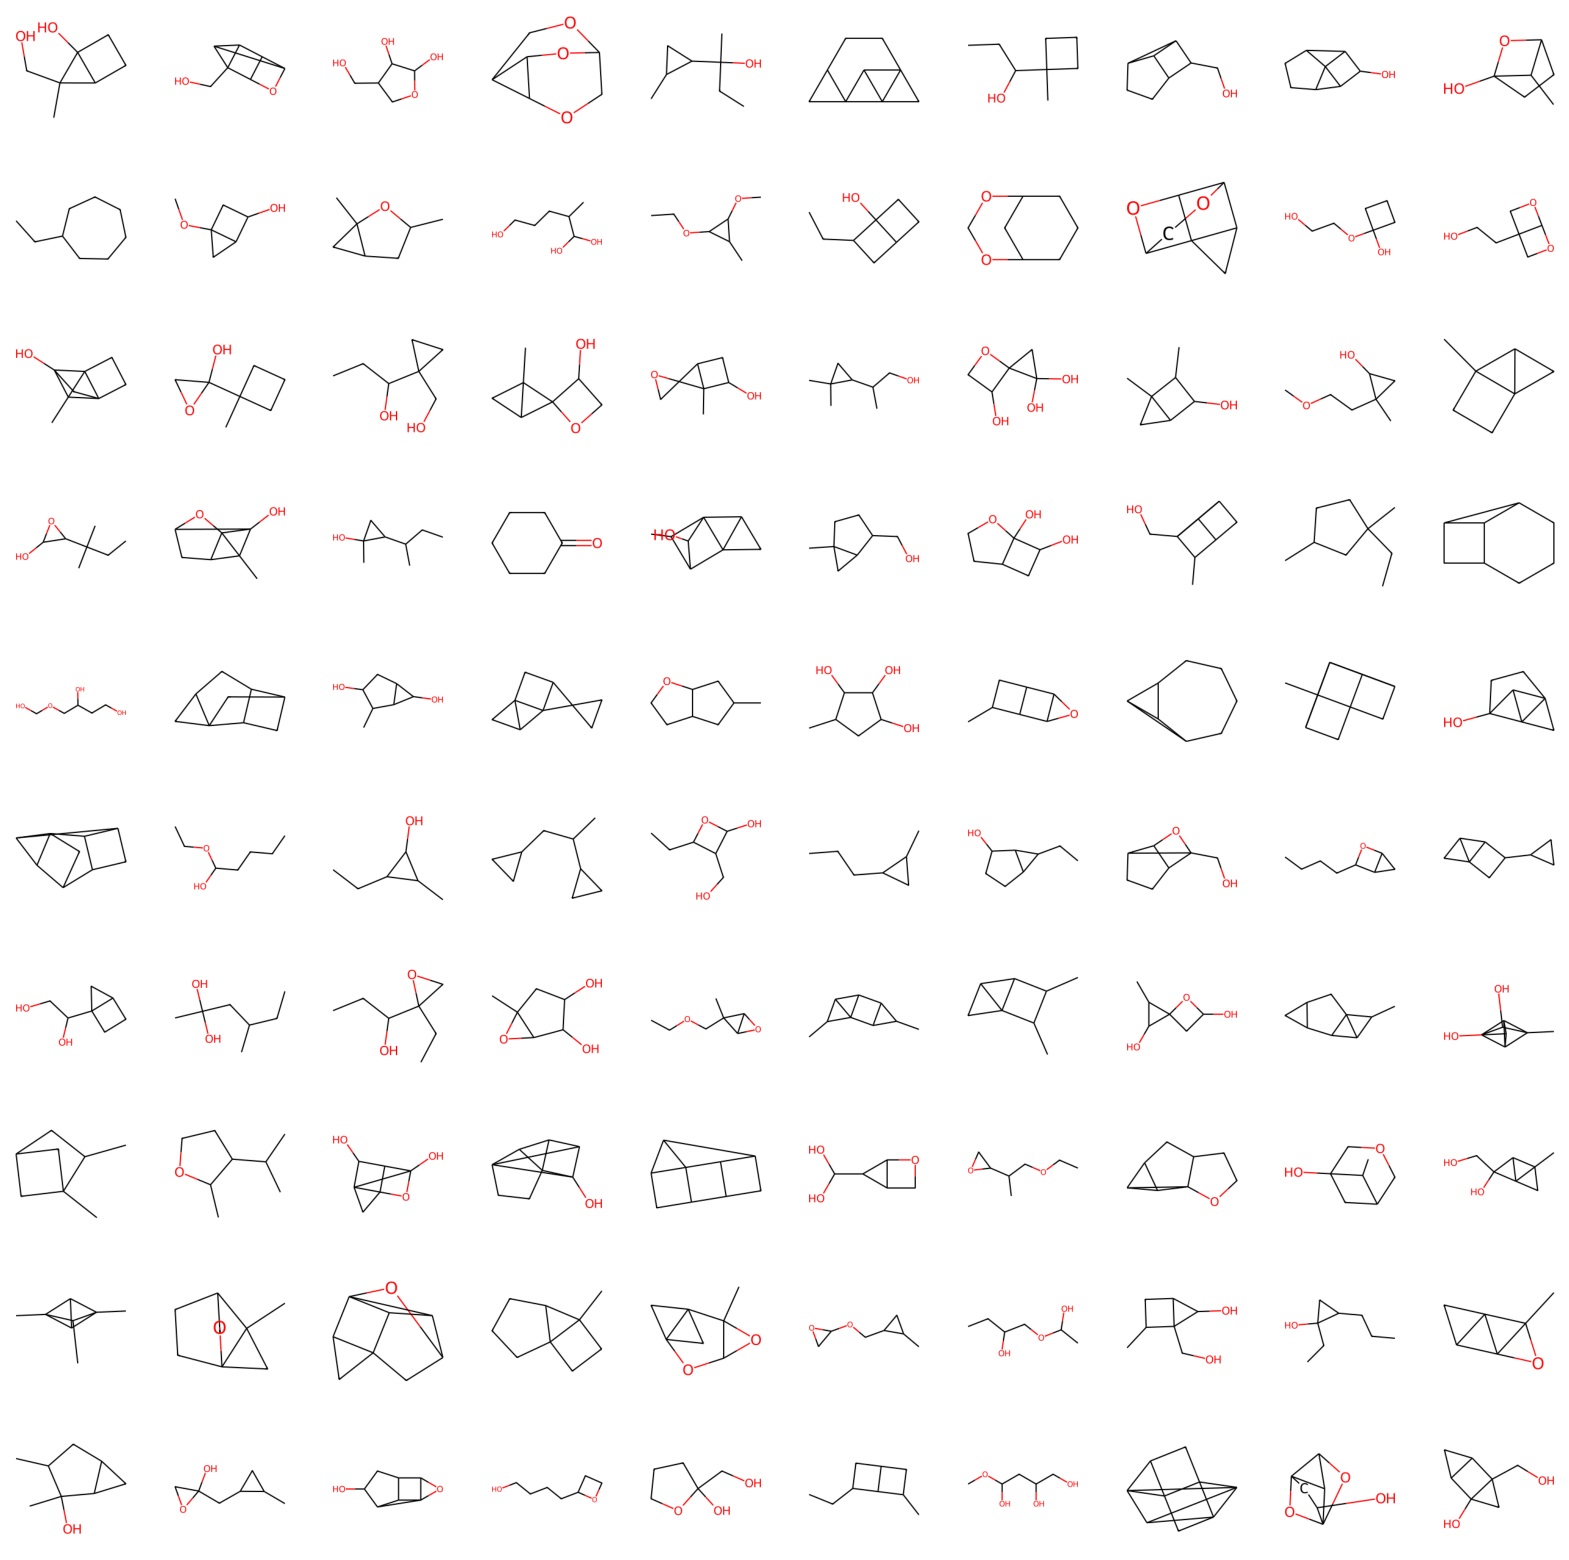

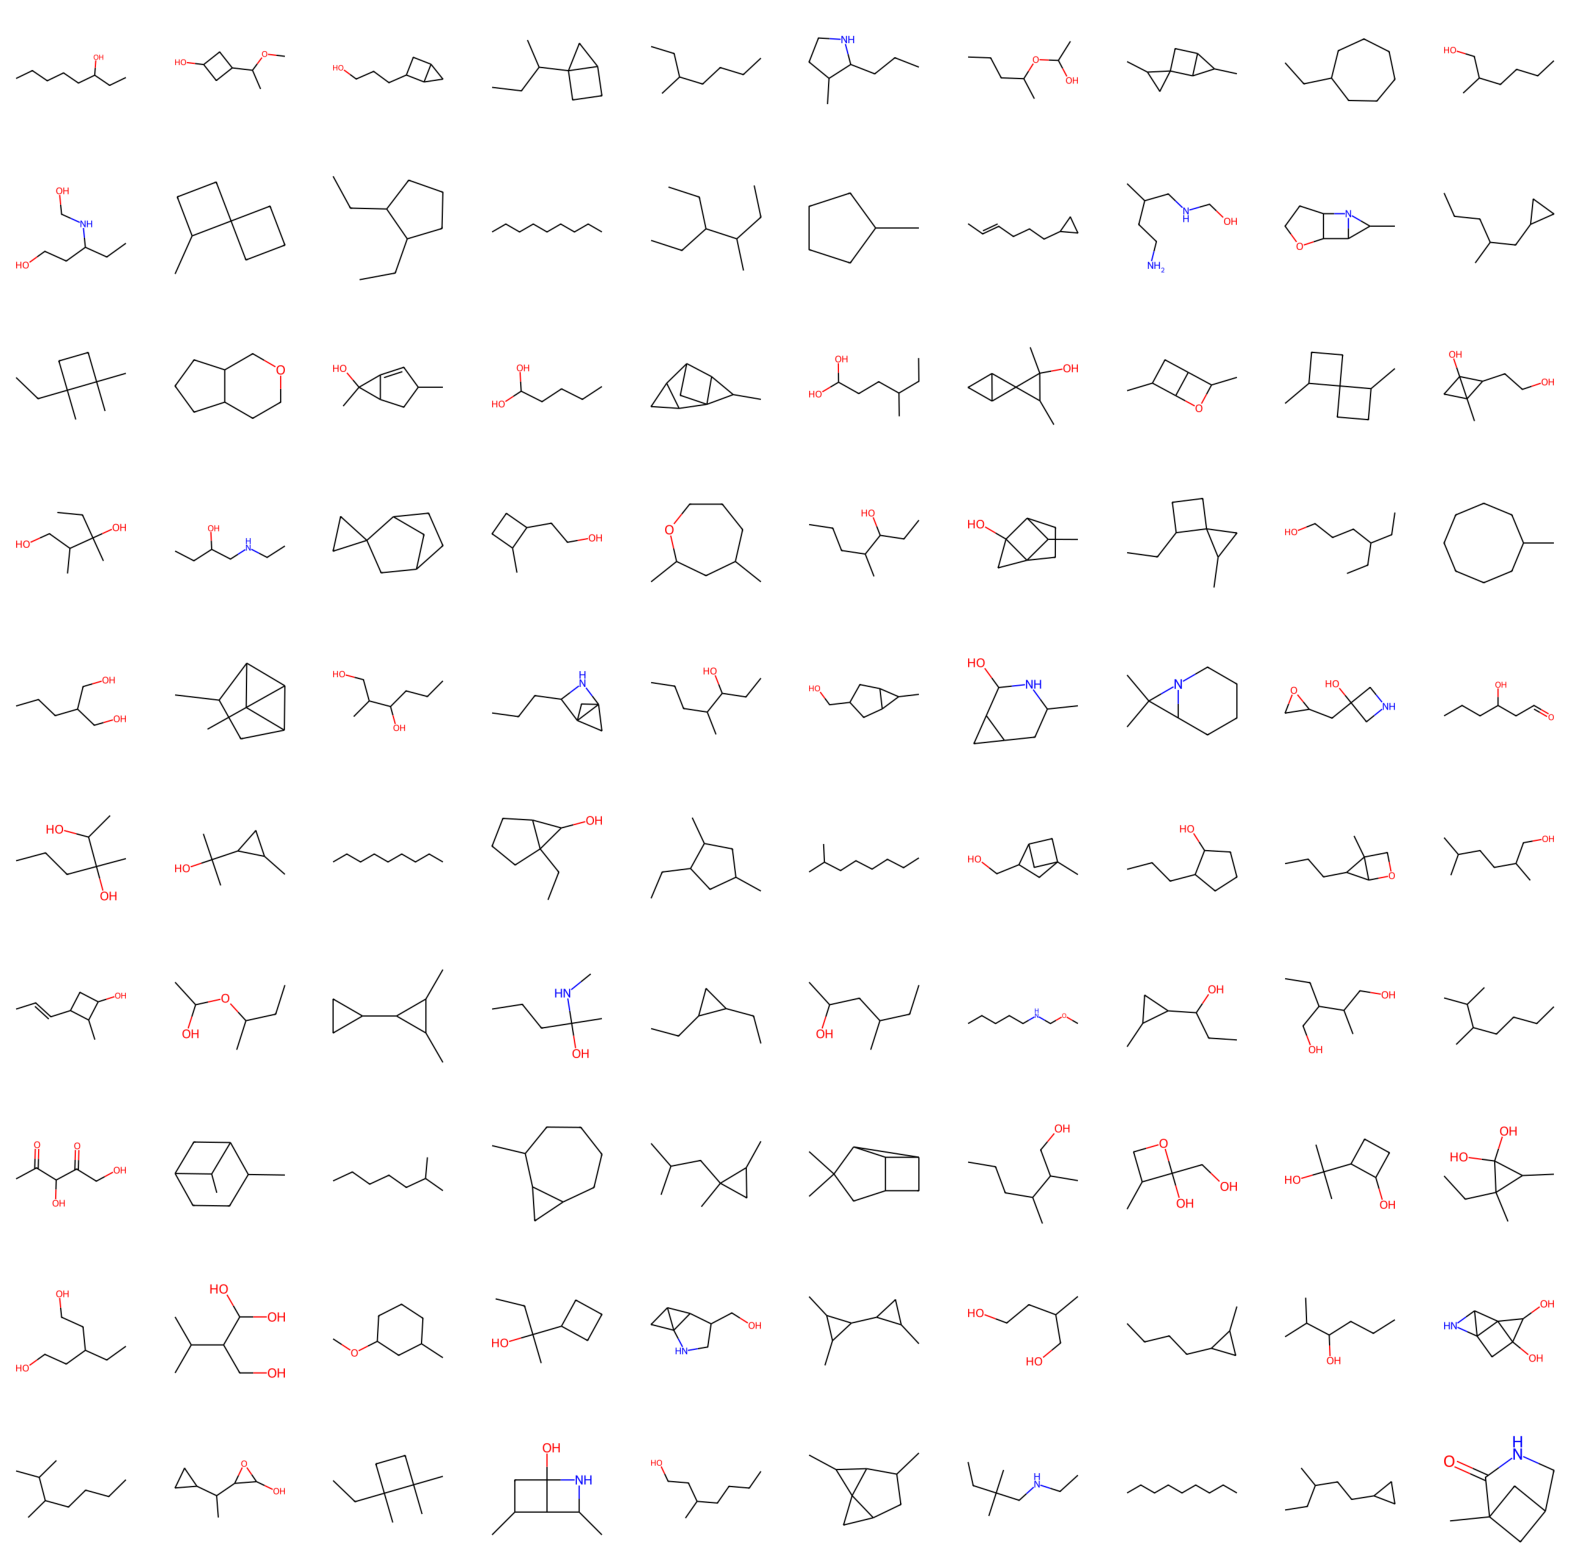

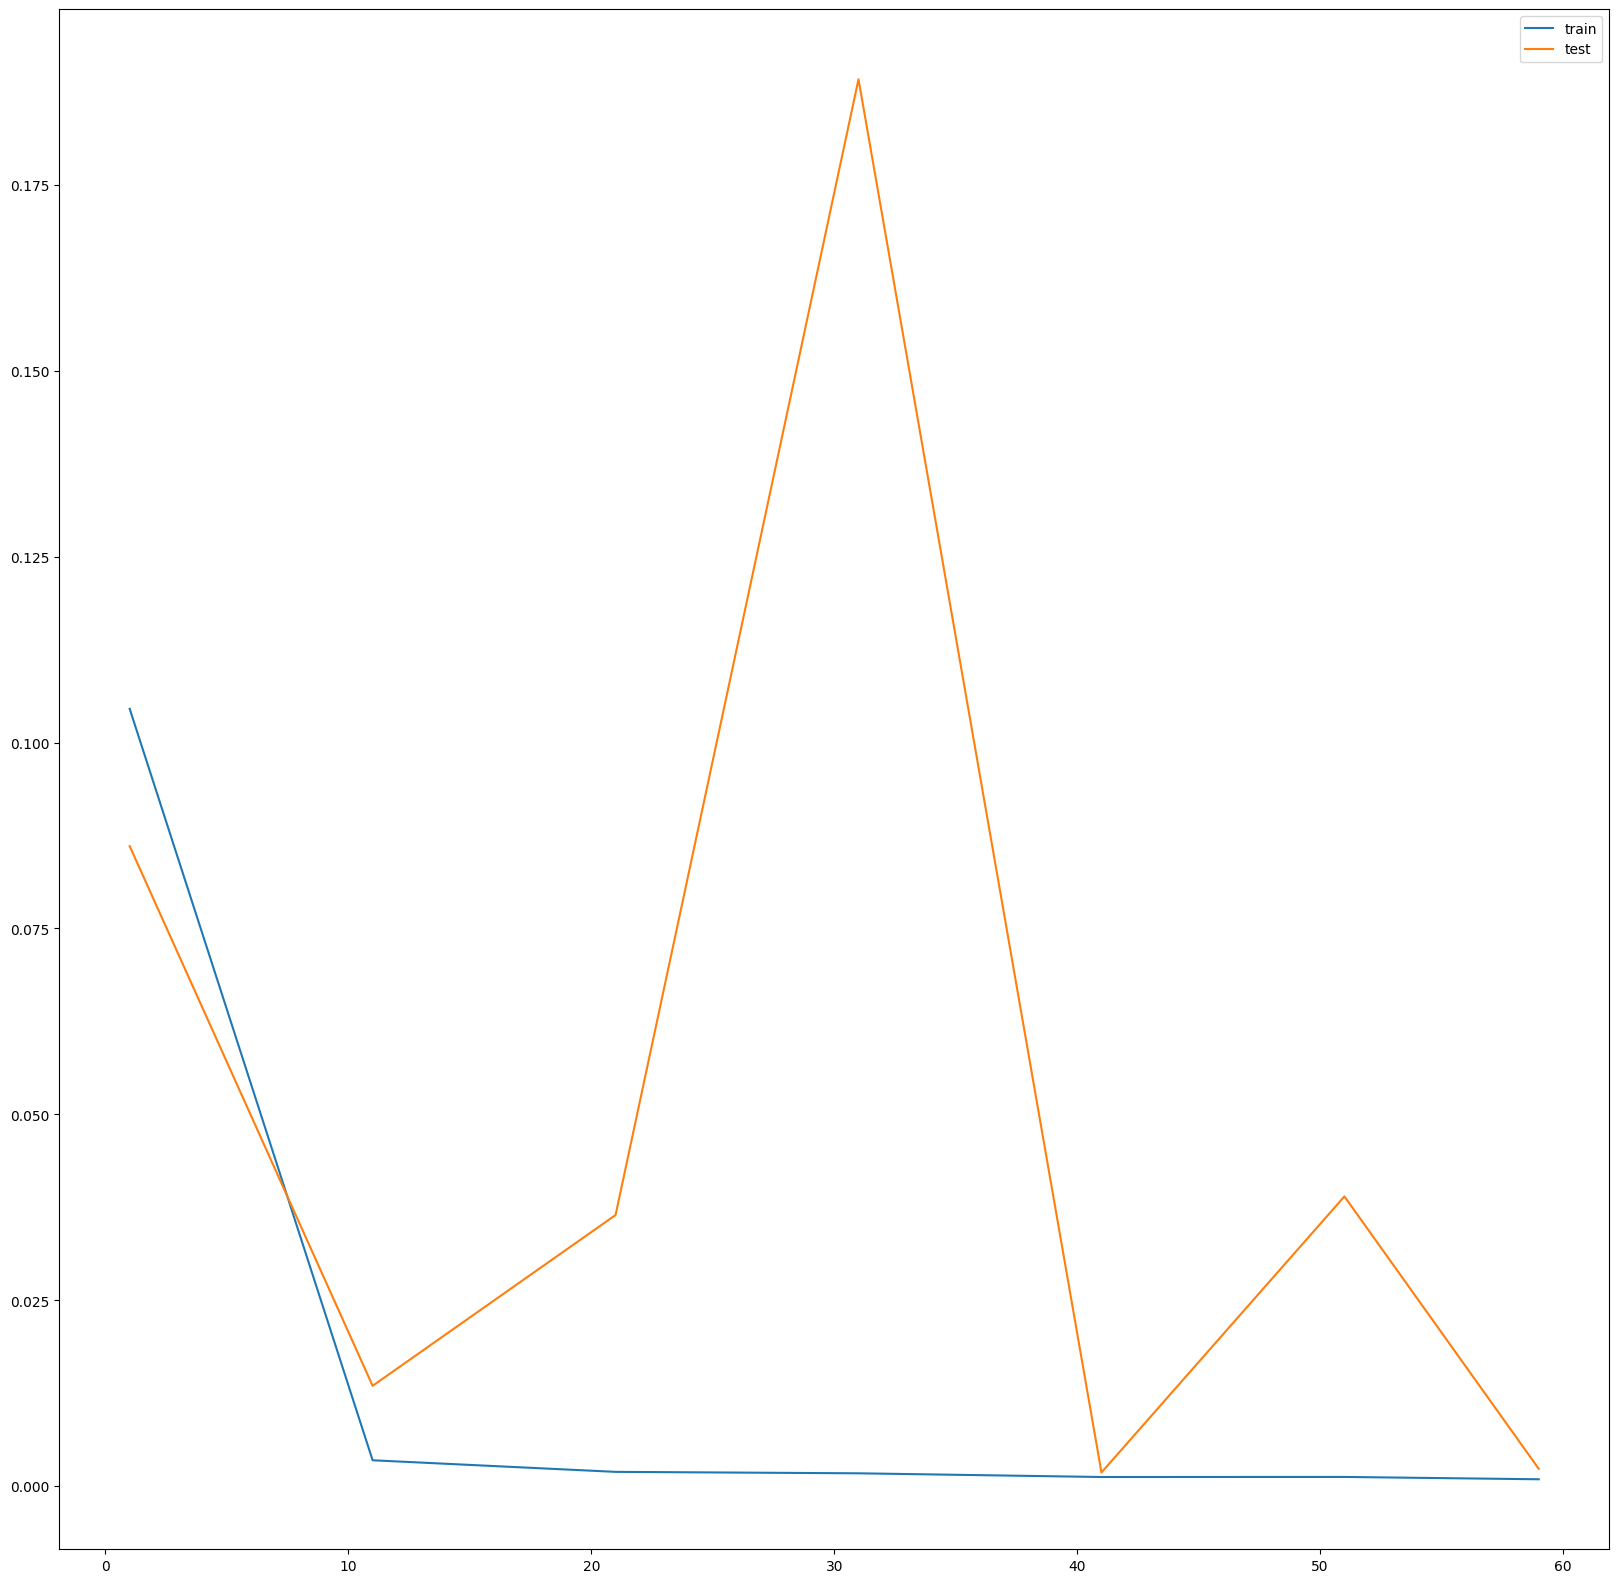

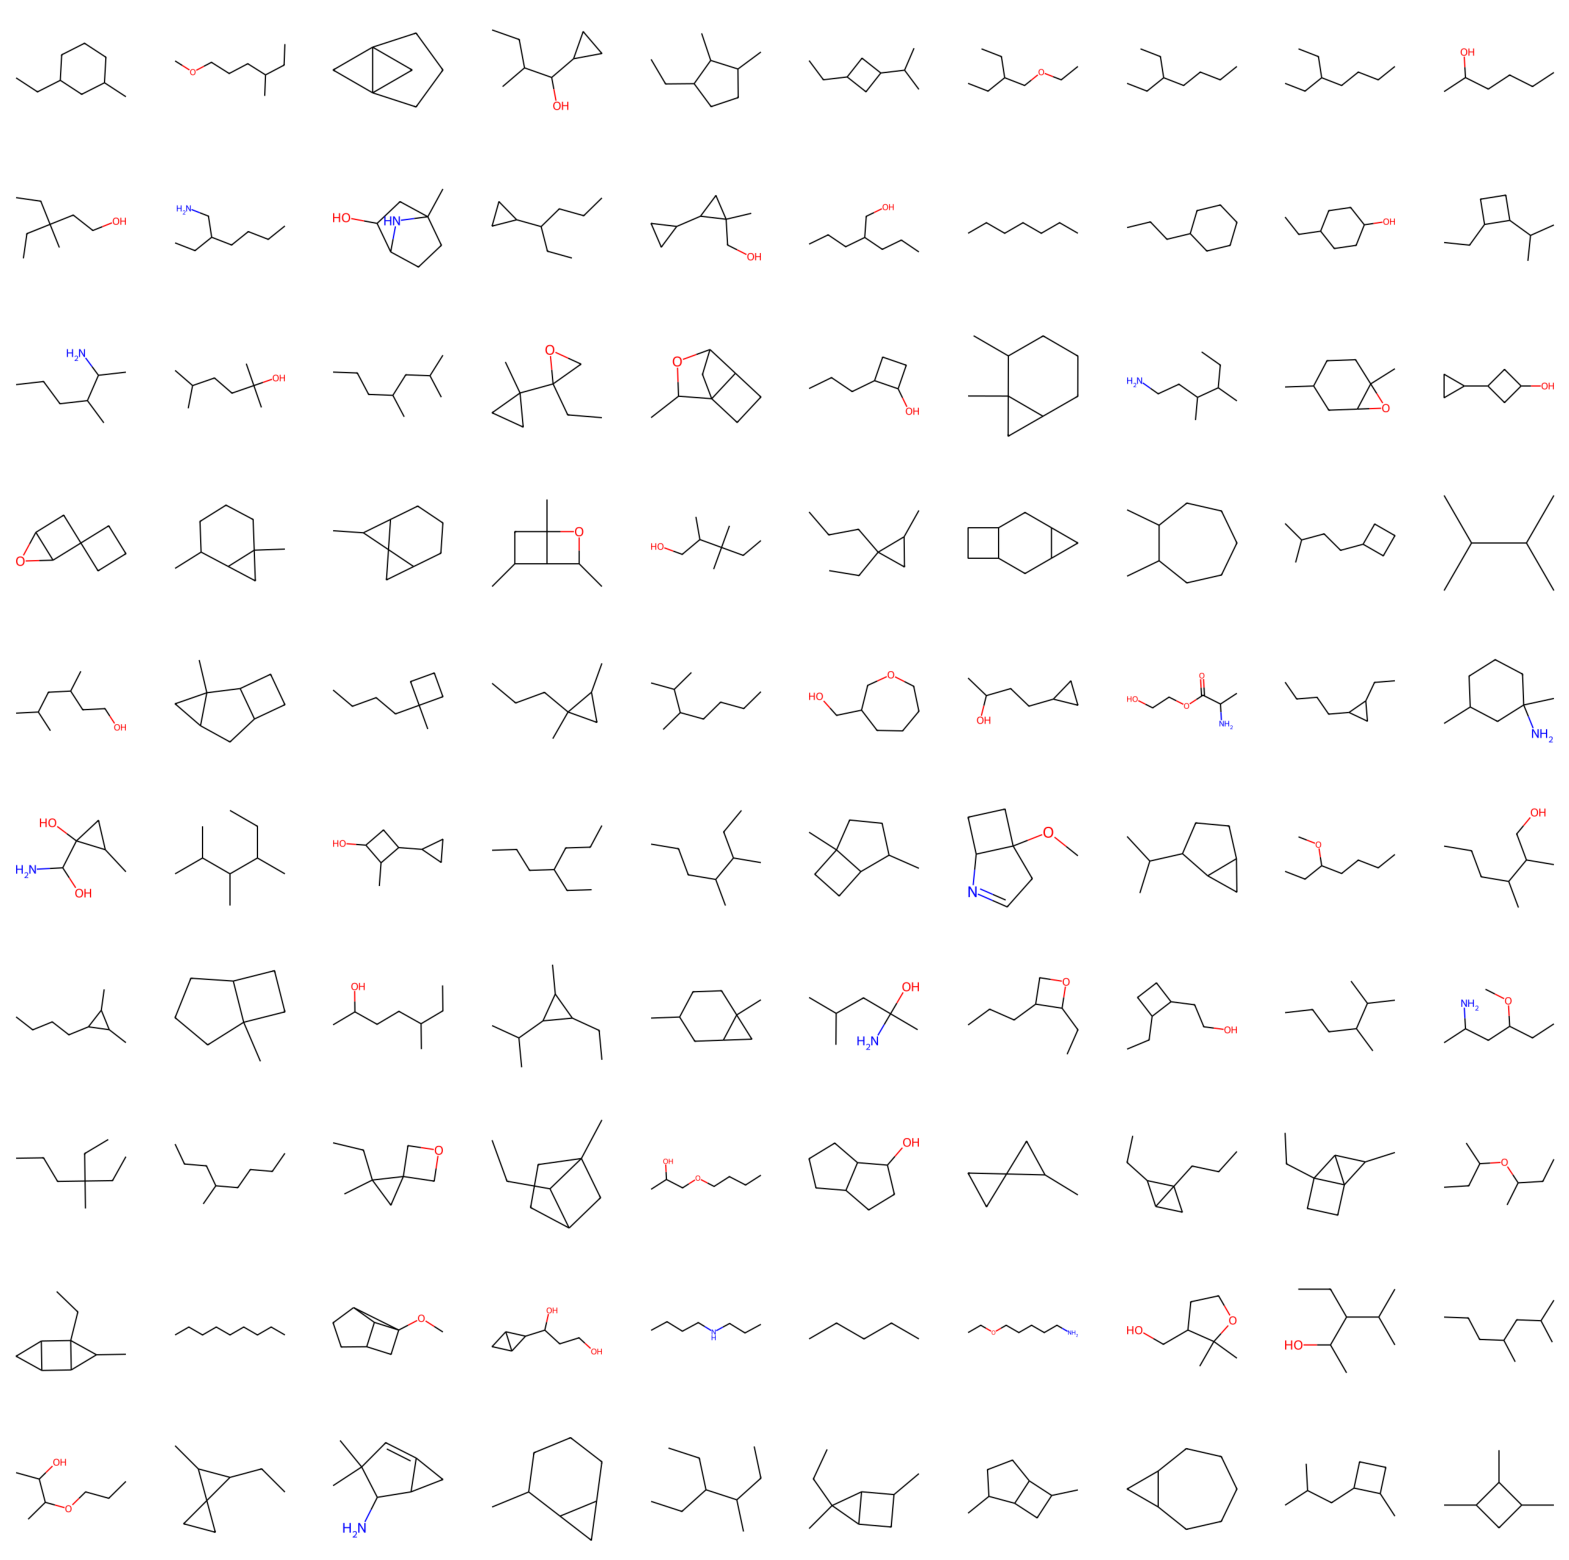

Error in callback <function _WandbInit._pause_backend at 0x7f71e55bc0d0> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

In [ ]:
start_with_wandb()
start_with_wandb(set_baseline_true=True)